In [15]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']

In [119]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [9, 9, 9] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,10),np.logspace(-4,0,10),np.linspace(20,40,10)]
labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 8

In [120]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded.root")
f_preunfold = ur.open("./preunfold.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_true = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
if closure:
    h3_true = f_preunfold["true"]
    h1_true = f_preunfold["true1D"]

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])


In [121]:
proj = lambda a : np.array([projectionX(a.to_numpy()[0]), projectionY(a.to_numpy()[0]), projectionZ(a.to_numpy()[0])]).T

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_G = proj(h3_true)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]


[   6996.  198930.  899270. 1837774. 1971298. 1096622.  239746.   11582.
       0.]
[1.00000000e-05 3.59381366e-05 1.29154967e-04 4.64158883e-04
 1.66810054e-03 5.99484250e-03 2.15443469e-02 7.74263683e-02
 2.78255940e-01 1.00000000e+00]


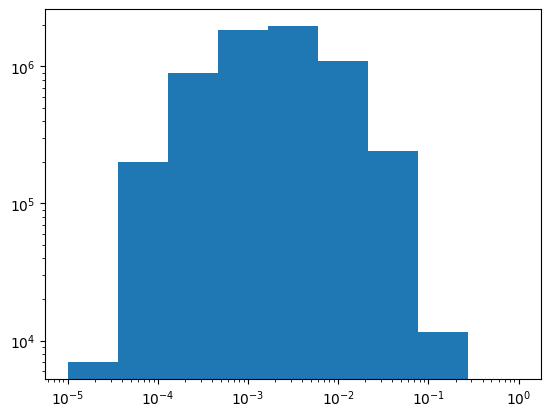

In [122]:
print(theta0_G[:,0])
print(binning[0])

plt.hist(binning[0][:-1], binning[0], weights=theta0_G[:,0])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [123]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][:,1])

[5.45833333e+00 2.15293569e+02 8.21768616e+02 5.55024176e+03
 3.81452816e+04 3.01070420e+05 1.97194640e+06 7.79246142e+06
 3.75552529e+06]
[4.72155444e+00 2.16511398e+02 7.88115895e+02 5.57056222e+03
 3.82446400e+04 3.02503435e+05 1.97720537e+06 7.80844928e+06
 3.76080764e+06]
[4.26215126e+00 2.23034897e+02 7.79135395e+02 5.59354188e+03
 3.82057918e+04 3.02616523e+05 1.97707399e+06 7.80949329e+06
 3.76232938e+06]
[3.95158056e+00 2.31912696e+02 7.84728551e+02 5.61681702e+03
 3.81683378e+04 3.02637063e+05 1.97665723e+06 7.80874459e+06
 3.76253694e+06]
[3.73262438e+00 2.41614527e+02 7.98707258e+02 5.63425245e+03
 3.81365433e+04 3.02661972e+05 1.97636640e+06 7.80816992e+06
 3.76242227e+06]
[3.57331866e+00 2.51366095e+02 8.17515840e+02 5.64497791e+03
 3.81094221e+04 3.02697016e+05 1.97622124e+06 7.80803149e+06
 3.76228959e+06]
[3.45422807e+00 2.60736417e+02 8.38911339e+02 5.65002576e+03
 3.80858972e+04 3.02738833e+05 1.97619247e+06 7.80828068e+06
 3.76222189e+06]
[3.36296608e+00 2.69479152e

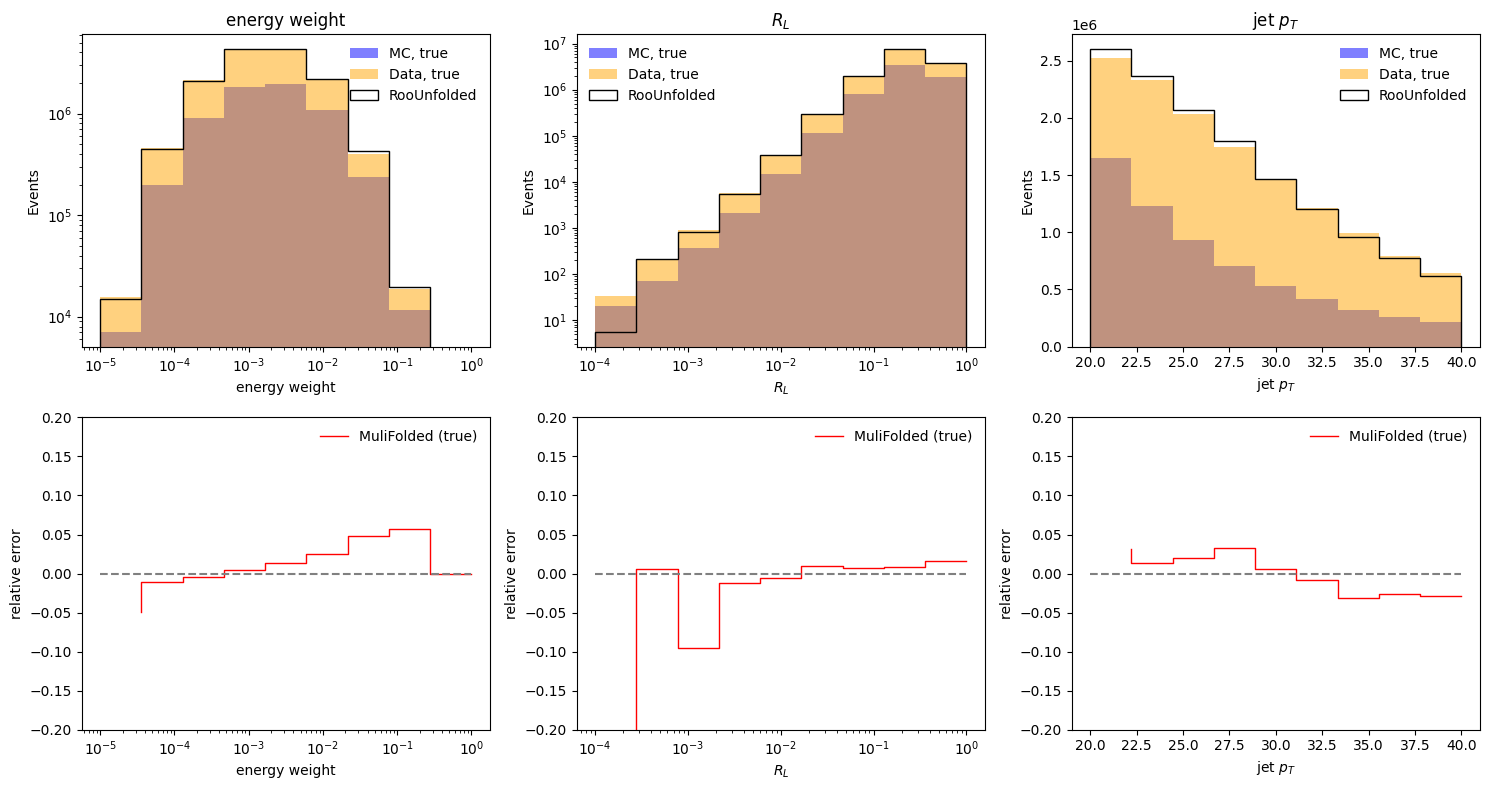

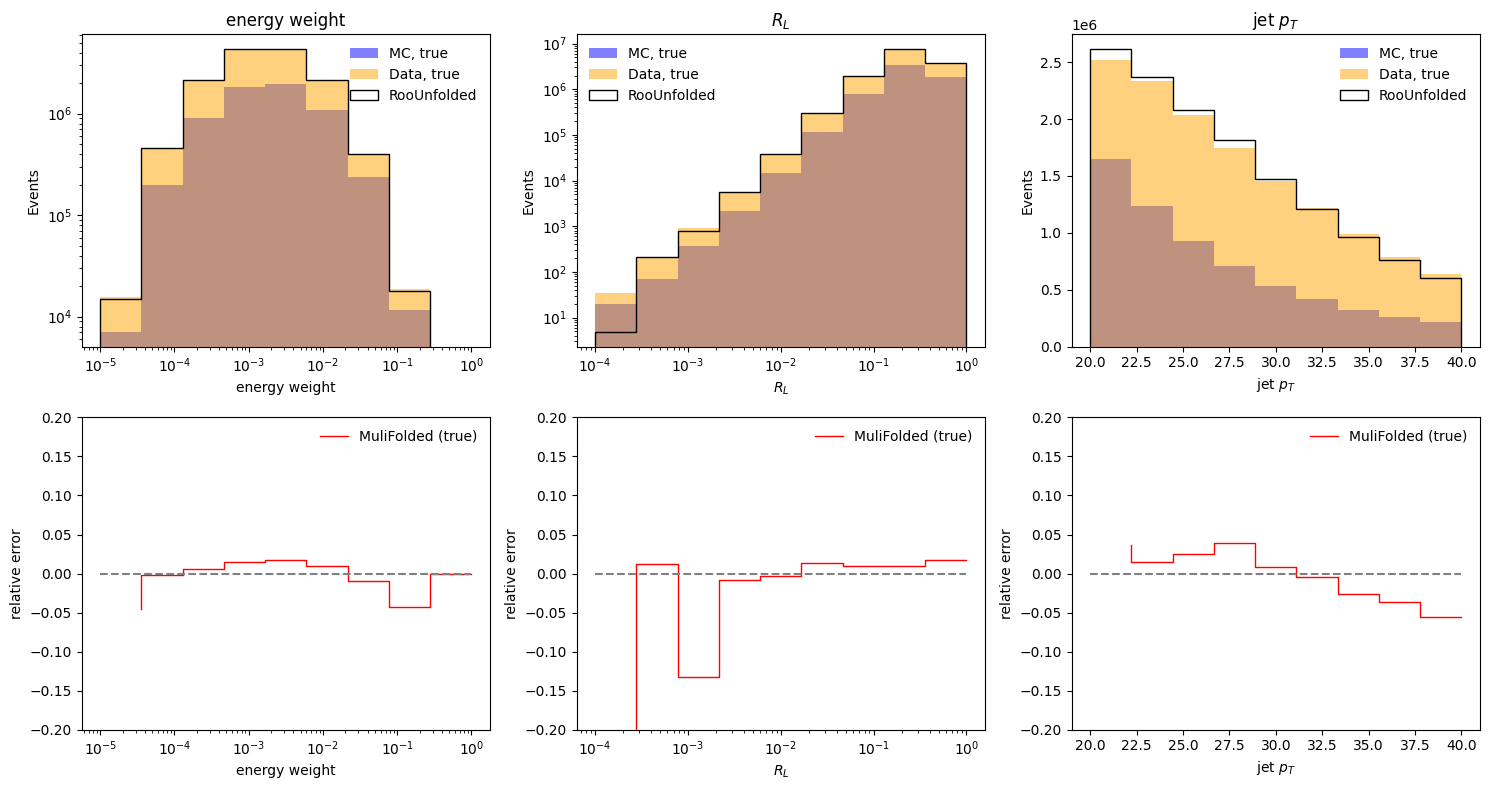

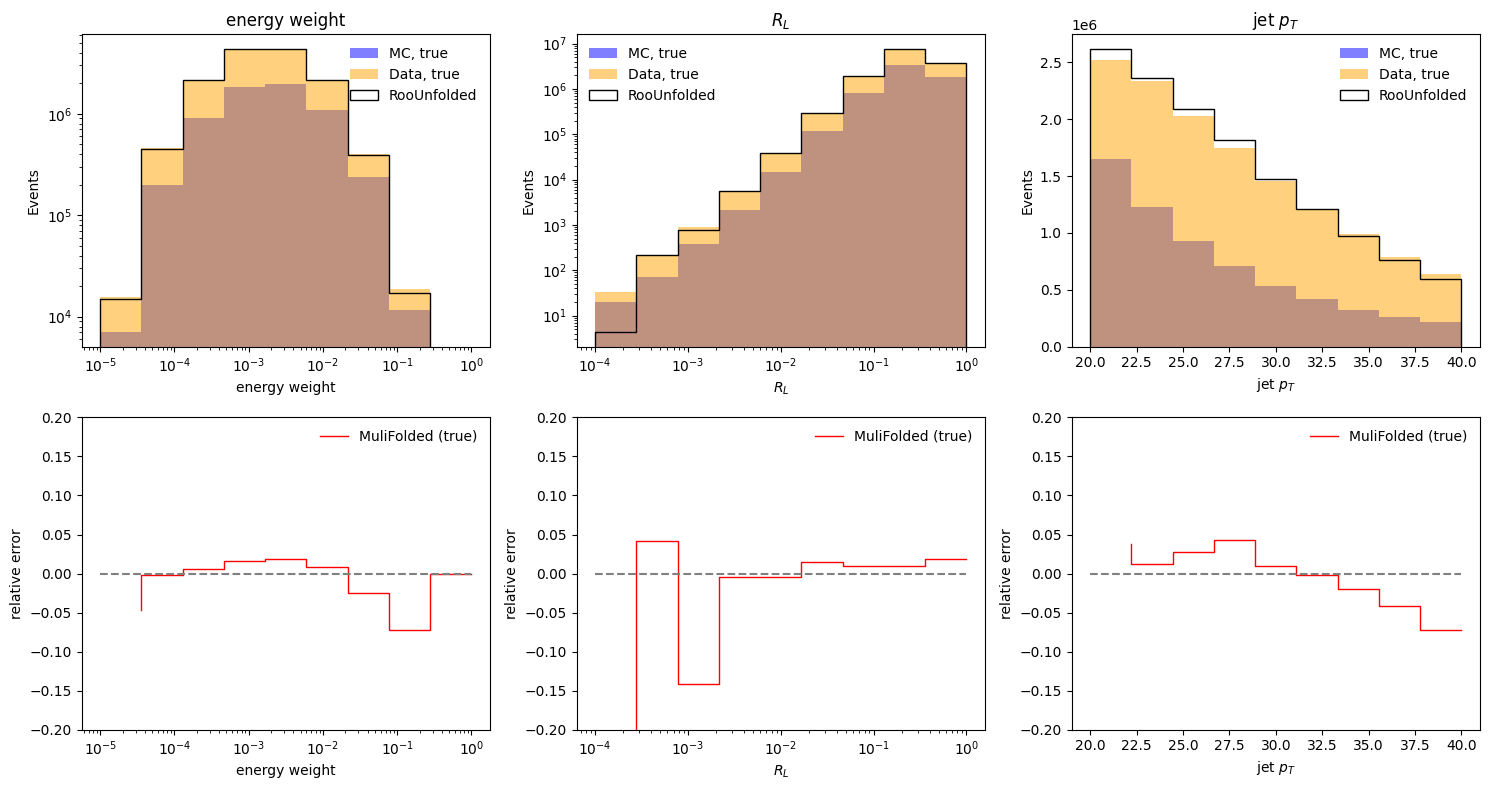

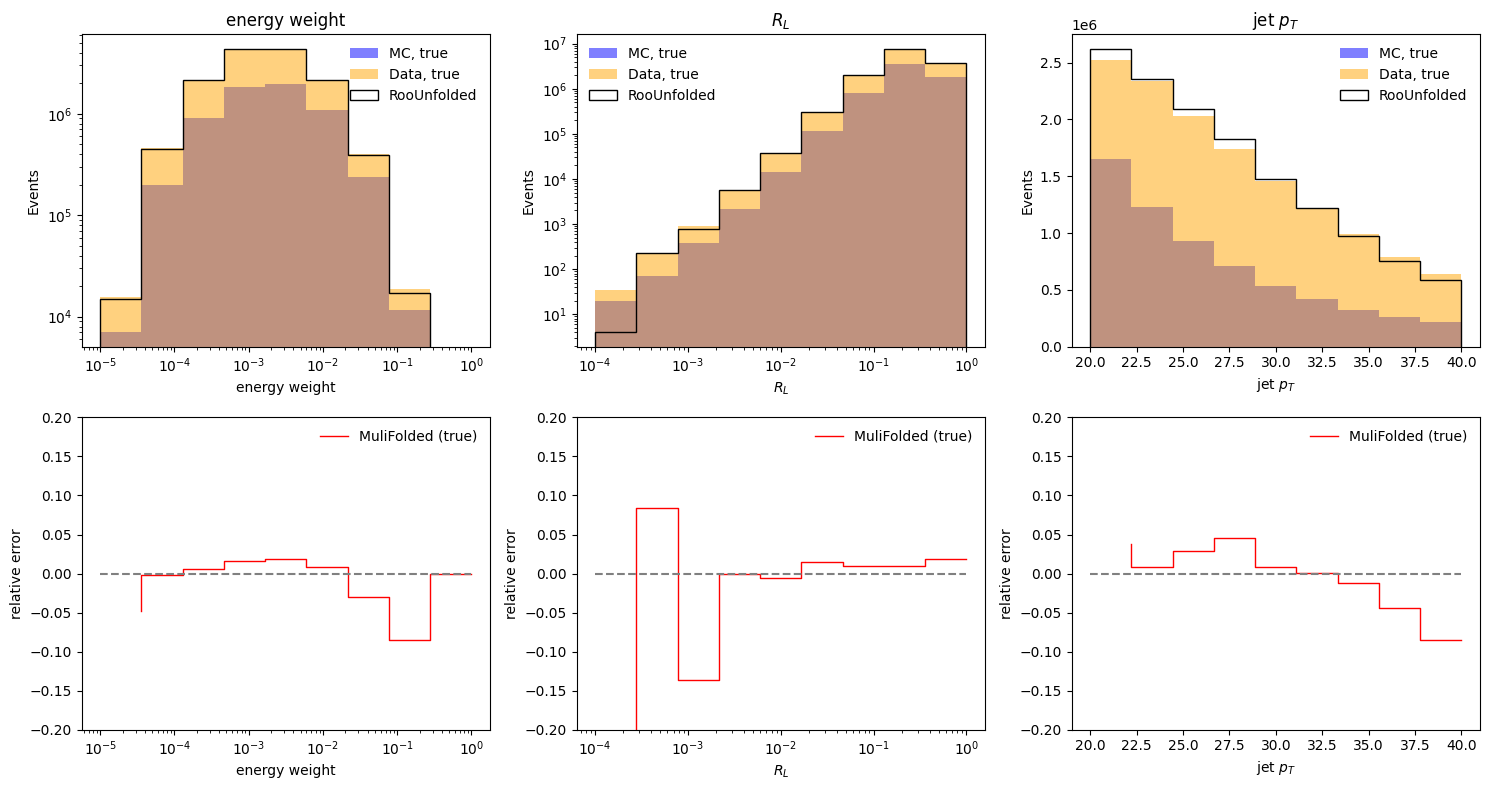

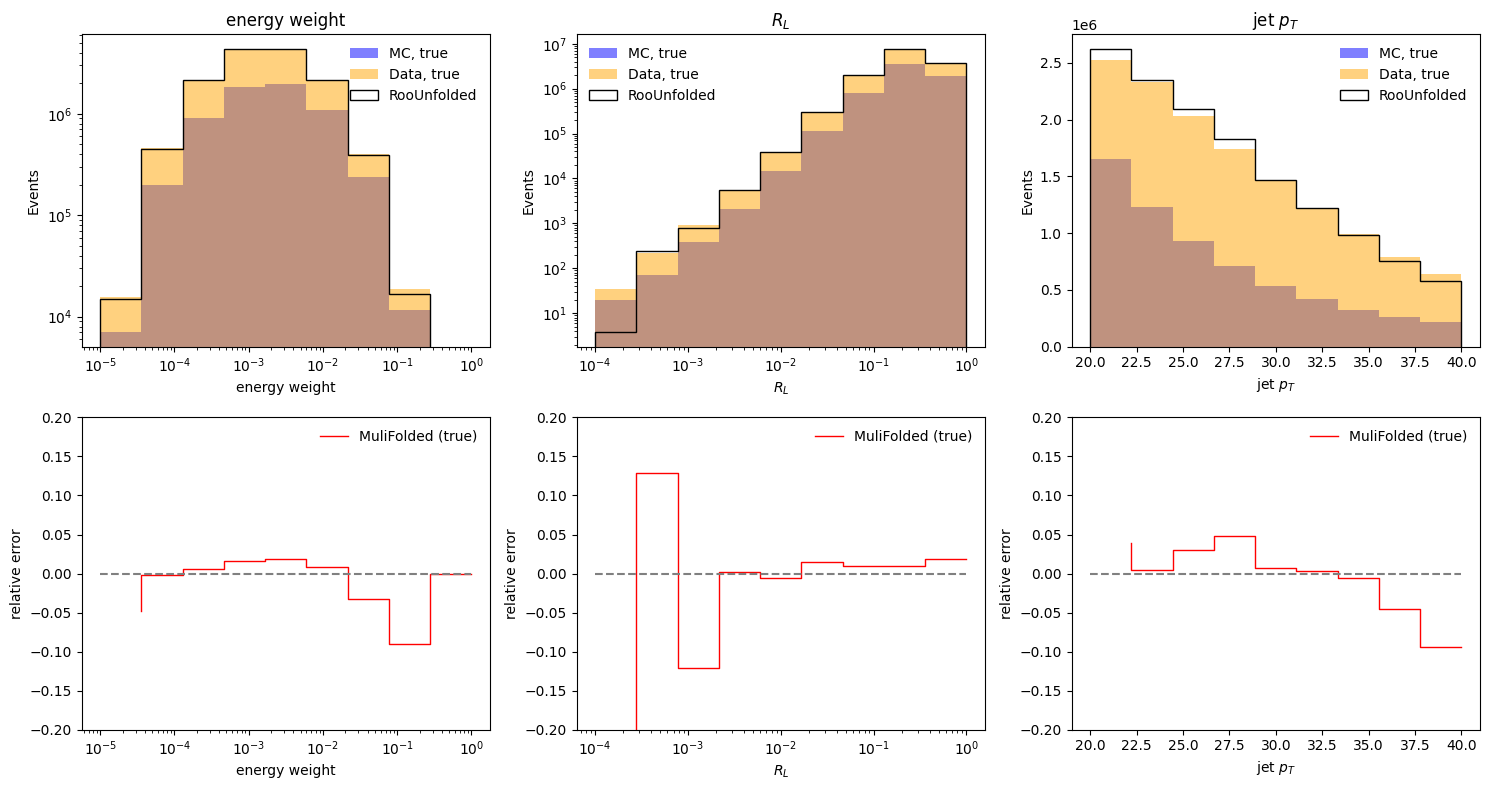

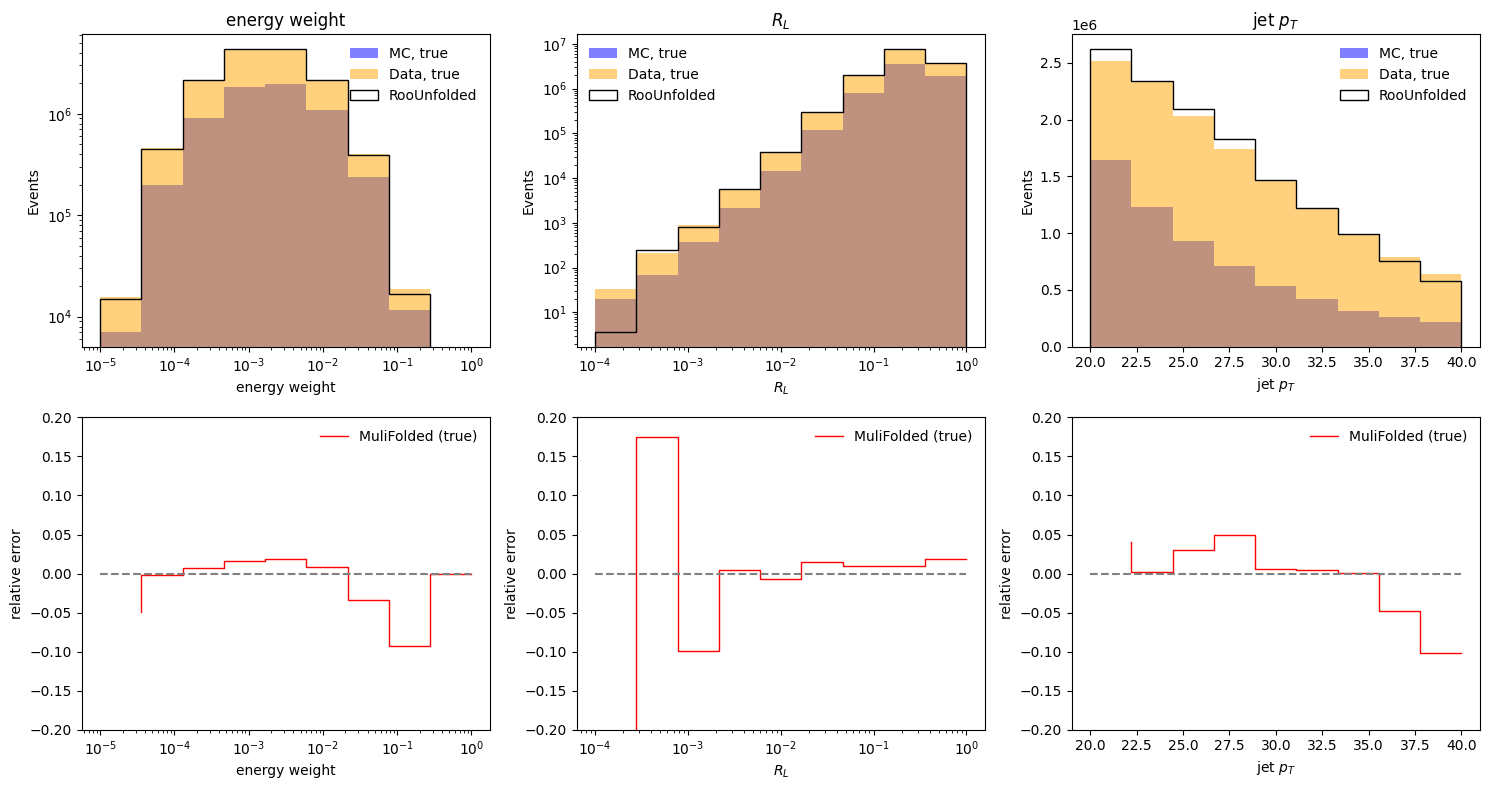

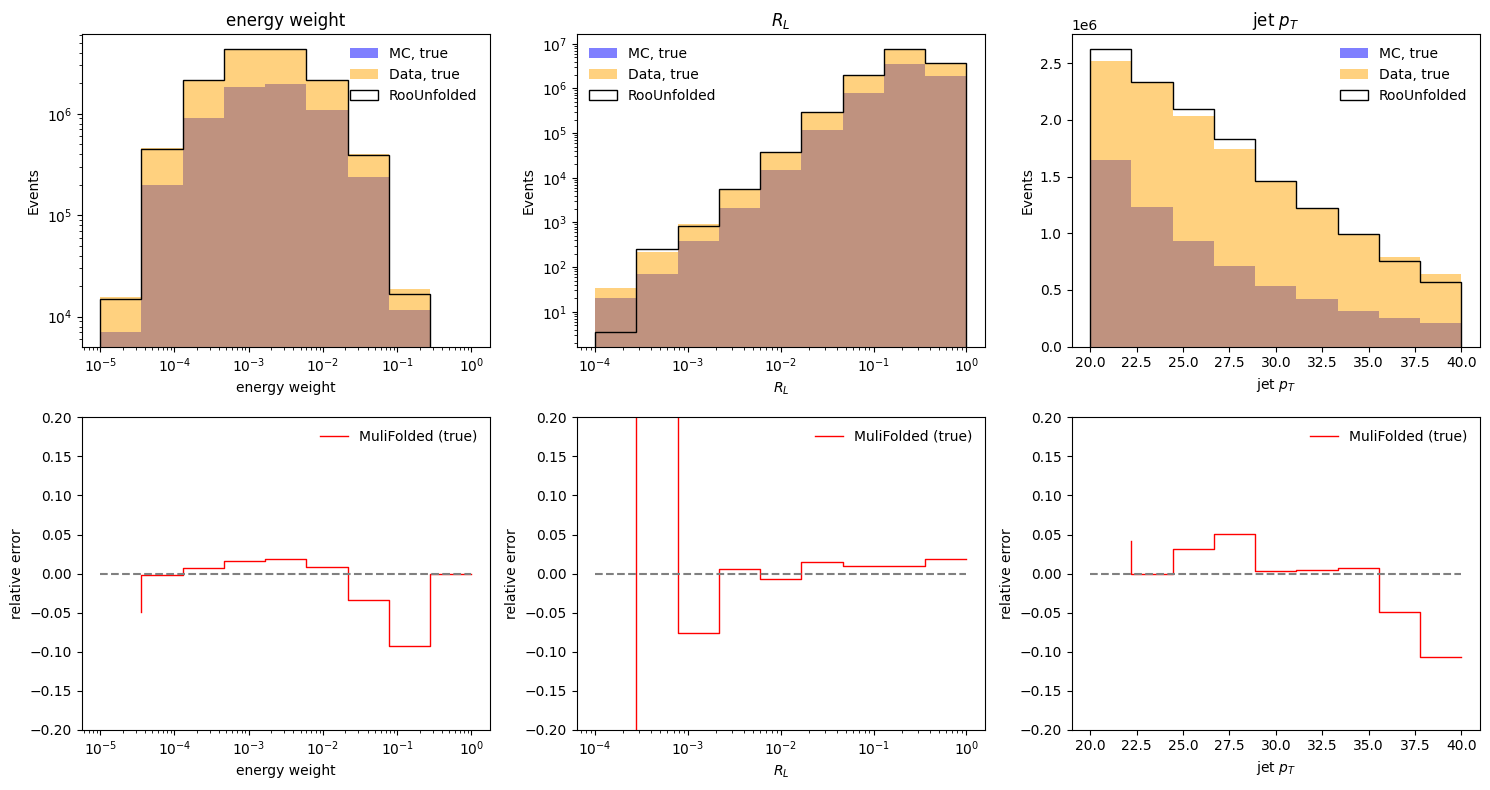

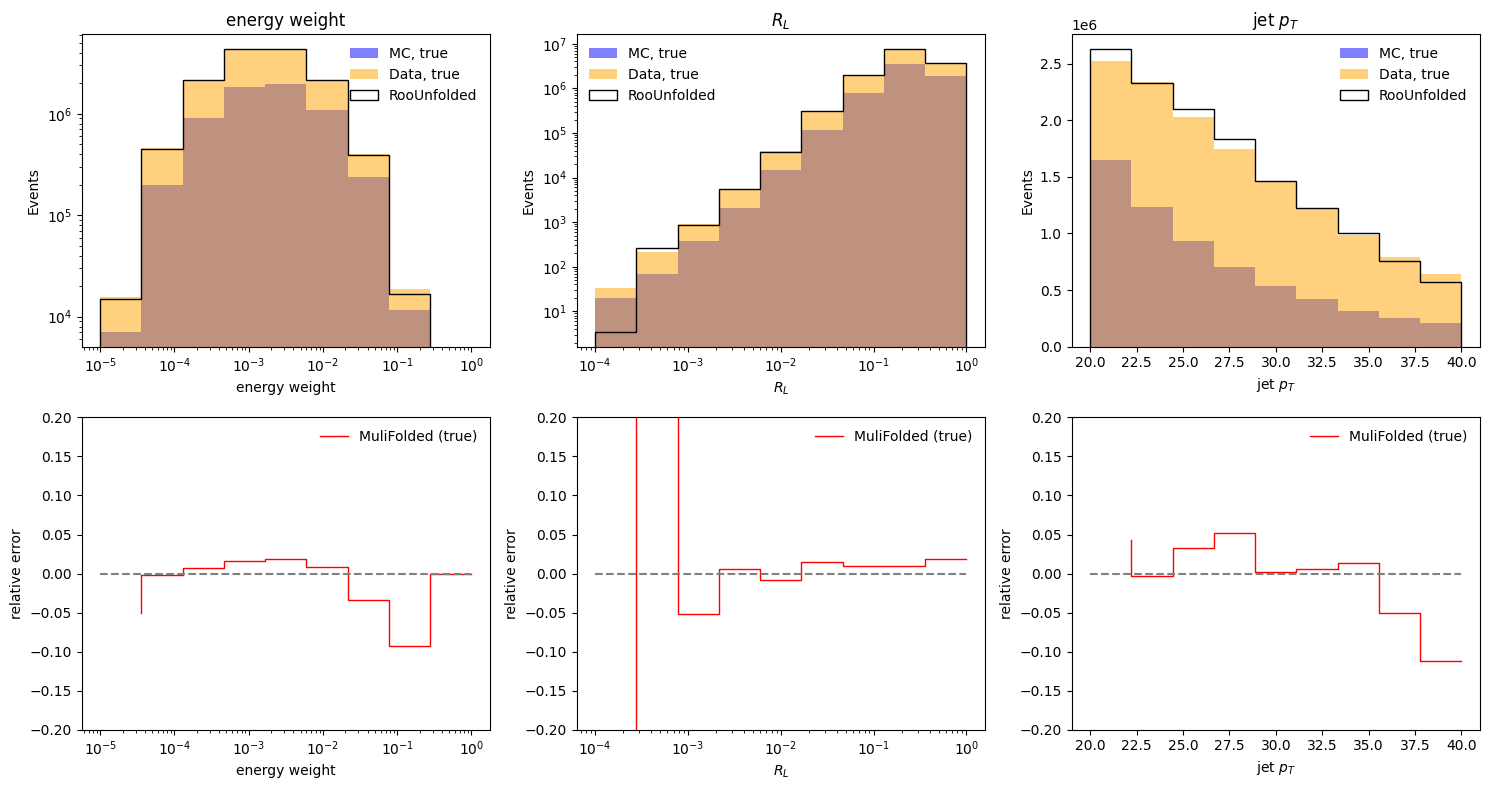

In [144]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

for iteration in range(8):
    fig, axes = plt.subplots(2, 3, figsize=(15,8))

    # ROW 1: raw distributions
    for i in range(3):
        ax = axes[0, i]

        _,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta0_G[:,i],color='blue', alpha=0.5, label="MC, true")
        true_hist,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta_unknown_G[:,i],color='orange',alpha=0.5,label="Data, true")
        unfolded_hist,_,_=ax.hist(binning[i][:-1], binning[i],weights=theta_unfolded[iteration][:,i],color='black',histtype="step",label="RooUnfolded",lw=1)
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Events")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
    
    # ROW 2: residual plots
    for i in range(3):
        ax = axes[1, i]
        
        # particle-level
        unfolded_hist, _ = np.histogram(binning[i][:-1], binning[i], weights=theta_unfolded[iteration][:,i])
        true_hist, _ = np.histogram(binning[i][:-1], binning[i], weights=theta_unknown_G[:,i])
        err_hist = np.divide(unfolded_hist-true_hist, true_hist, out=np.zeros_like(unfolded_hist-true_hist), where=true_hist!=0)
                             
        ax.step(binning[i][1:],err_hist,where="pre",color='red',label="MuliFolded (true)",lw=1)
        ax.hlines(y=0, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_xlabel(labels[i])
        ax.set_ylabel("relative error")
        ax.legend(frameon=False)
        
        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_ylim([-0.2, 0.2])
        else:
            ax.set_ylim([-0.2, 0.2])

    
    fig.tight_layout()
    # fig.savefig("post_training_" + str(iteration) + ".png")
    # fig.show()
    # plt.close()
plt.show()

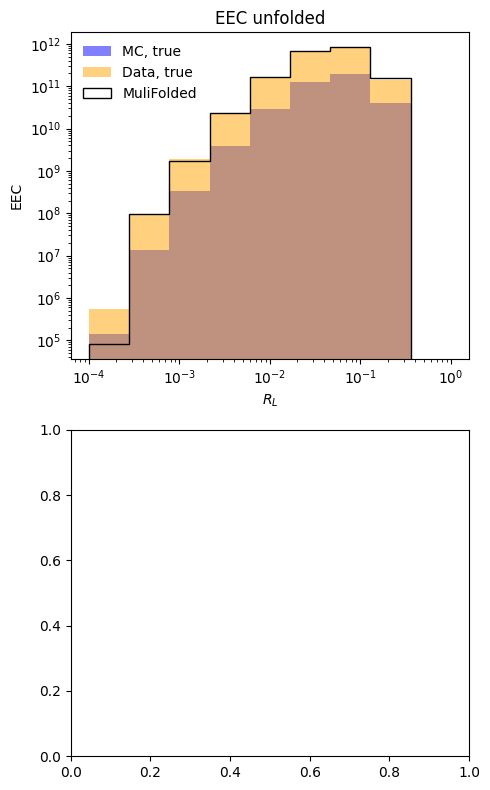

In [151]:
############################## UNFOLDED EEC ############################
# individual distros

for iteration in range(1):
    fig, axes = plt.subplots(2, 1, figsize=(5,8))

    # ROW 1: EEC distribution
    ax = axes[0]

    _,_,_=ax.hist(binning[1][:-1], binning[1], weights=theta0_G[:,1]*theta0_G[:,0], color='blue', alpha=0.5, label="MC, true")
    _,_,_=ax.hist(binning[1][:-1], binning[1], weights=theta_unknown_G[:,1]*theta_unknown_G[:,0], color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(binning[1][:-1], binning[1], weights=theta_unfolded[iteration][:,1]*theta_unfolded[iteration][:,0], color='black',histtype="step",label="MuliFolded",lw=1)


    ax.set_title("EEC unfolded")
    ax.set_xlabel("$R_L$")
    ax.set_ylabel("EEC")
    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_yscale('log')

    if i in [0, 1]:
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_ylim([0.1, 4E8])
    
    # ROW 2: residual plots
        """
    for i in range(3):
        ax = axes[1, i]
        
        # particle-level
        unfolded_hist, _ = np.histogram(binning[i][:-1], binning[i], weights=theta_unfolded[iteration][:,i])
        true_hist, _ = np.histogram(binning[i][:-1], binning[i], weights=theta_unknown_G[:,i])
        err_hist = np.divide(unfolded_hist-true_hist, true_hist, out=np.zeros_like(unfolded_hist-true_hist), where=true_hist!=0)
                             
        ax.step(binning[i][1:],err_hist,where="pre",color='red',label="MuliFolded (true)",lw=1)
        ax.hlines(y=0, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_xlabel(labels[i])
        ax.set_ylabel("relative error")
        ax.legend(frameon=False)
        
        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_ylim([-0.2, 0.2])
        else:
            ax.set_ylim([-0.2, 0.2])
            """

    
    fig.tight_layout()
    # fig.savefig("post_training_" + str(iteration) + ".png")
    # fig.show()
    # plt.close()
plt.show()